# Natural Gas Price Analysis
In this task, we extrapolate natural gas price from historical data of the commodities market.

First, we import and visualize the data.

In [1]:
import csv
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np

file_path = "data/Nat_Gas.csv" # assuming you are in the same directory as the 'data' folder
dates = []
prices = []

# Create a simple time-series plot function
def plt_plot(y, x=None, x_label=None, y_label=None, title=None):
    if ( x is None ) or ( isinstance(x, (list, np.ndarray)) and len(x) == 0 ):
        x = np.arange(0, len(y))
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

with open(file_path, mode="r", encoding="utf-8") as file:
    reader = csv.reader(file)
    header = next(reader)

    for row in reader:
        date_str, price_str = row
        
        # parse elements from string into appropriate, plottable format
        dates.append(datetime.strptime(date_str, "%m/%d/%y"))
        prices.append(float(price_str))



In [2]:
# Display the labels for both axes
header

['Dates', 'Prices']

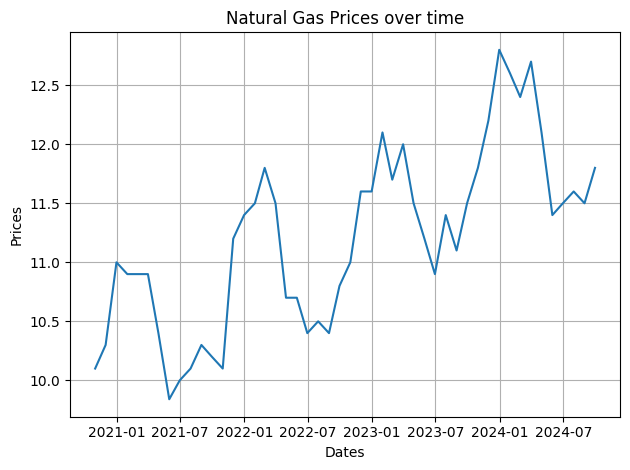

In [3]:
plt_plot(x=dates, y=prices, x_label=header[0], y_label=header[1], title="Natural Gas Prices over time")

## Basic Analysis
We will calculate **descriptive statistics** and identify seasonality and periodicity through **frequency analysis** using:
- (a) Fast Fourier Transform (FFT) and 
- (b) Autocorrelation Function (ACF)

In [4]:
min_price = min(prices)
max_price = max(prices)
average_price = sum(prices) / len(prices)

print(f"""
Minimum price: {min_price}
Maximum price: {max_price}
Average price: {average_price:.2f}
""")


Minimum price: 9.84
Maximum price: 12.8
Average price: 11.21



In [5]:
from scipy.fft import fft, fftfreq

N = len(dates)
fs = 12 # sampled monthly, 12 months = 1 year 

vals = abs(fft(prices))
vals = vals[0:N//2]
freqs = fftfreq(N, d=1/fs)
freqs = freqs[:N//2]

power_spectrum = np.abs(vals)**2

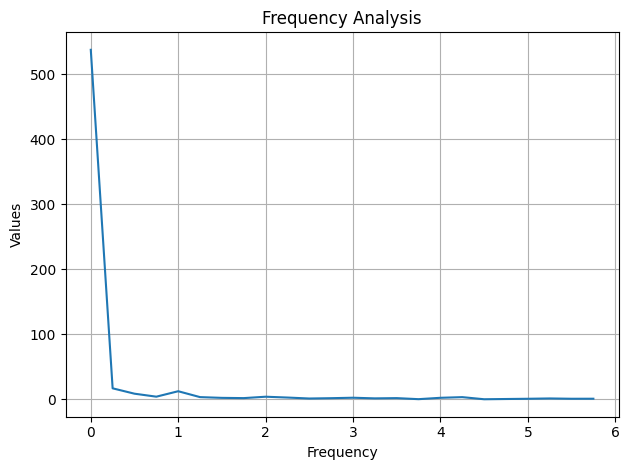

In [6]:
plt_plot(x=freqs, y=vals, x_label="Frequency", y_label="Values", title="Frequency Analysis")

In FFT Analysis, to find meaningful seasonal or periodic signals, we ignore the first peak at 0 and look for the **second peak**, which typically represents the dominant cyclic frequency in the data. We can clearly see that the second peak is at 1. Since our sampling rate is 12 (i.e., 12 months), a frequency index of 1 represents 1 year.

In [7]:
from scipy.signal import correlate, find_peaks

def autocorrelate(x):
    x = np.array(x)
    x -= np.mean(x)  # Demean
    result = correlate(x, x, mode="full")
    result = result / (np.var(x) * len(x))  # Normalize by variance
    result = result[len(result)//2:]  # Keep non-negative lags
    return result


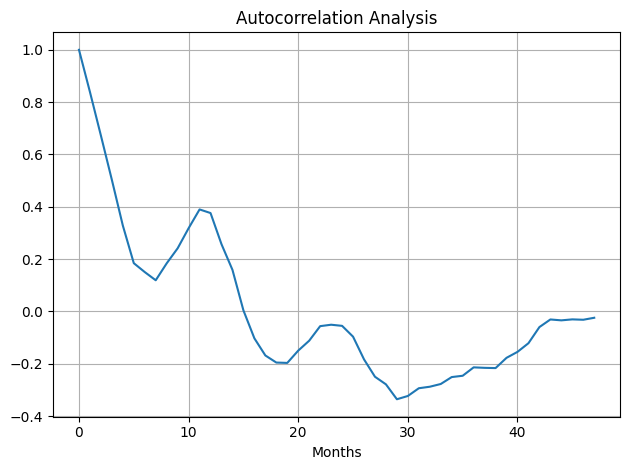

In [8]:
acf = autocorrelate(prices)
plt_plot(y=acf, x_label="Months", title="Autocorrelation Analysis")

In [9]:
peaks, _ = find_peaks(acf)
peaks

array([11, 23, 36, 43, 45], dtype=int64)

In Autocorrelation, the **first peak** after lag 0 indicates the time lag at which the signal most strongly correlates with itself again, revealing the periodicity.

For instance, a peak at lag = 11 months suggests the pattern roughly repeats every 11 months.

## Interpretation
### Descriptive Statistics
- Minimum Price: USD 9.84
- Maximum Price: USD 12.80
- Average Price: USD 11.21
  
The price data spans nearly four years, showing modest fluctuation within a relatively stable range. The lowest recorded price occurred around May 2021, while the highest price peaked in December 2023, reflecting seasonal trends and possible market stress periods.

### Seasonality & Periodicity
Two independent signal analysis methods were applied to identify cyclical behavior:
- FFT (Fast Fourier Transform) Analysis confirms a dominant cycle at 12 months, indicating strong annual seasonality in the price signal.
- Autocorrelation Analysis suggests a dominant periodicity of 11 months. This implies that price patterns tend to repeat nearly every year, though with some phase shift or irregularity in timing.

The small discrepancy between the autocorrelation and FFT results likely reflects the influence of noise, short-term trends, or slightly varying seasonal effects from year to year.

### Indication
The data indicates that natural gas storage prices exhibit consistent yearly seasonality, with values tending to peak and dip in roughly the same months each year. This is expected in energy markets, where seasonal demand patterns (e.g., winter heating needs or summer cooling demand) drive storage behavior and pricing.

The close alignment of the FFT and autocorrelation results strengthens the conclusion that a 12-month cycle is the dominant underlying rhythm in the data.


## Discussion
### Perspective 1: Seasonal Predictability for Strategic Planning
From a market operations standpoint, the clear evidence of annual seasonality identified through both FFT and autocorrelation suggests that <u>natural gas storage prices are highly predictable on a yearly cycle</u>. But real-world events clearly influence these patterns:

- **Extreme weather**: The severe Winter Storm Uri in February 2021 caused dramatic price spikes and prompted legal actions due to alleged supply restrictions [(1)](https://www.oenb.at/en/Publications/Economics/reports/2024/report-2024-10-why-natural-gas-prices-rose-markedly-2021/html-version.html)
- **Climate variability**, including early cold snaps or heatwaves, intensified demand peaks—especially in early 2021 and 2022 [(2)](https://iea.blob.core.windows.net/assets/14a61f2b-04fa-4a9d-a78b-6c22fc23d5c8/GasMarketReport,Q3-2024.pdf)

With prices ranging moderately between USD 9.84 and USD 12.80, stakeholders can **model risk** with more confidence and **optimize storage schedules** based on seasonal demand cycles.

### Perspective 2: Limitations of Regularity in Real-World Forecasting
Despite the statistical regularity observed, the slight difference in periodicity estimates (11 vs. 12 months) points to potential instability or drift in real-world cycles. External factors such as policy changes, extreme weather events, or geopolitical influences could disrupt the expected seasonal rhythm. 
- The **Russia–Ukraine conflict** beginning February 2022 triggered global supply concerns. U.S. LNG exports to Europe surged, pushing U.S. storage prices upward [(1)](https://www.oenb.at/en/Publications/Economics/reports/2024/report-2024-10-why-natural-gas-prices-rose-markedly-2021/html-version.html)
- U.S. policy responses (e.g., Biden pausing LNG export approvals to consider environmental impacts) delayed additional supply capacity [(2)](https://iea.blob.core.windows.net/assets/14a61f2b-04fa-4a9d-a78b-6c22fc23d5c8/GasMarketReport,Q3-2024.pdf)

Therefore, while annual patterns are strong, relying solely on historical seasonality may oversimplify market dynamics. Models incorporating exogenous variables or adaptive seasonality could offer more robust forecasting under volatile conditions.